In [6]:
# Calculate tuning curves for drifting gratings
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
sys.path.append("../../CPC/dpc")
sys.path.append("../../CPC/backbone")

from python_dict_wrapper import wrap

from tqdm import tqdm
import collections
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap

import tables
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

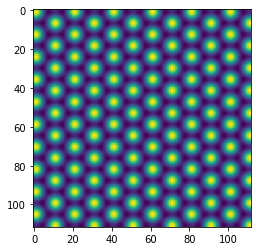

In [2]:
omega0 = .1
xi, yi = np.meshgrid(np.arange(112), np.arange(112))
xi -= 1
yi -= 1
baseline = 0

ri = xi
t = 0
a = np.cos(2*np.pi*ri*omega0)-baseline
t += a

theta = np.pi * 2 / 3
ri = np.cos(theta) * xi + np.sin(theta) * yi
a = np.cos(2*np.pi*ri*omega0)-baseline
t += a

theta = np.pi * 4 / 3
ri = np.cos(theta) * xi + np.sin(theta) * yi
a = np.cos(2*np.pi*ri*omega0)-baseline
t += a

t = t * 1/3

plt.imshow(t)

In [3]:
features = 'airsim_04'

args = wrap({'features': features,
             'ckpt_root': '../pretrained',
             'slowfast_root': '../../slowfast',
             'ntau': 32,
             'nt': 1,
             'subsample_layers': False})

from fmri_models import get_feature_model

model, hooks, data = get_feature_model(args)

def forward_each(model, hooks, X):
    model.eval()
    latents = collections.defaultdict(lambda: [])
    for i in tqdm(range(X.shape[0])):
        with torch.no_grad():
            if X.shape[2] >= 20:
                X_ = X[i:i+1, 5:-5, :, :]
                
            else:
                X_ = X[i:i+1, :, :, :]
                
            X_ = np.stack([X_, X_, X_], axis=1)
            _ = model(torch.tensor(X_, dtype=torch.float))
        
        for key in hooks.keys():
            Z = hooks[key]
            latents[key].append(Z[:, :, :, Z.shape[3] // 2, Z.shape[4] // 2].mean(axis=2).squeeze())
    
    responses = {}
    for key in hooks.keys():
        responses[key] = np.stack(latents[key], axis=0)
        
    return responses

Map out receptive fields using small patches of moving stimuli.

In [4]:
# Map out the receptive fields
xi, yi = np.meshgrid(np.arange(112), np.arange(112))

patch_size = 8

M = []

for i in range(0, 112, patch_size):
    for j in range(0, 112, patch_size):
        rgy = slice(i, i + patch_size)
        rgx = slice(j, j + patch_size)
        mask = np.zeros((112, 112), dtype=np.bool)
        mask[rgy, rgx] = True
        
        M.append(mask)
        
masks = np.stack(M, axis=0)
masks = masks.reshape((masks.shape[0], 1, masks.shape[1], masks.shape[2]))

theta = np.random.rand(masks.shape[0], 1, 1, 1) * 2 * np.pi
dt = np.random.randn(masks.shape[0], 1, 1, 1)
ilambdax = np.random.rand(masks.shape[0], 1, 1, 1) * .5

xi, yi, zi = np.meshgrid(np.arange(112), np.arange(112), np.arange(32))
xi = xi.transpose((2, 0, 1)).reshape((1, 32, 112, 112))
yi = yi.transpose((2, 0, 1)).reshape((1, 32, 112, 112))
zi = zi.transpose((2, 0, 1)).reshape((1, 32, 112, 112))

mi = xi * np.cos(theta.reshape(-1, 1, 1, 1)) + yi * np.sin(theta.reshape(-1, 1, 1, 1))
images = (masks * (np.cos(2 * np.pi * (mi + zi * dt) * ilambdax))).sum(axis=0)

In [7]:
class Gabors(nn.Module):
    def __init__(self, npatches=1):
        super().__init__()
        xi, yi = np.meshgrid(np.arange(112), np.arange(112))
        
        self.theta = nn.Parameter(torch.rand(npatches, 1, 1, 1) * 2 * np.pi)
        self.x0 = nn.Parameter(torch.randn(npatches, 1, 1, 1) * 5 + 112/2) 
        self.y0 = nn.Parameter(torch.randn(npatches, 1, 1, 1) * 5 + 112/2)
        self.sigmax = nn.Parameter(torch.randn(npatches, 1, 1, 1) * .1 + 3.0)
        self.sigmay = nn.Parameter(torch.randn(npatches, 1, 1, 1) * .1 + 3.0) 
        self.dt = nn.Parameter(torch.randn(npatches, 1, 1, 1))
        self.ilambdax = nn.Parameter(torch.rand(npatches, 1, 1, 1) * .5)
        self.A = nn.Parameter(torch.randn(npatches, 1, 1, 1) * 1)
        
        zi, xi, yi = torch.meshgrid(
            torch.arange(32), 
            torch.arange(112), 
            torch.arange(112)
        )
        xi = xi.unsqueeze(0)
        yi = yi.unsqueeze(0)
        zi = zi.unsqueeze(0)
        
        self.register_buffer('xi', xi)
        self.register_buffer('yi', yi)
        self.register_buffer('zi', zi)
    
    def forward(self):
        x0, y0, sigmax, sigmay = self.x0, self.y0, self.sigmax, self.sigmay
        theta, dt, ilambdax, A = self.theta, self.dt, self.ilambdax, self.A
        xi, yi, zi = self.xi, self.yi, self.zi
        
        mi = xi * torch.cos(theta.reshape(-1, 1, 1, 1)) + yi * torch.sin(theta.reshape(-1, 1, 1, 1))
        patches = torch.cos(2 * np.pi * (mi + zi * dt) * ilambdax)
        envs = torch.exp(-(xi - x0)**2/2/sigmax**2 - (yi - y0)**2/2/sigmay**2)
        images = (F.sigmoid(self.A) * patches * envs).sum(axis=0, keepdims=True)
        
        return torch.stack([images, images, images], axis=1)
    
import napari

g = Gabors()
g.to(device='cuda')
ims = g()

viewer = napari.Viewer()
viewer.add_image(ims.squeeze()[0, :, :, :].cpu().detach().numpy())

/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Image layer 'Image' at 0x7fe1ff356520>

In [30]:
class Dots(nn.Module):
    def __init__(self, npatches=1):
        super().__init__()
        xi, yi = np.meshgrid(np.arange(112), np.arange(112))
        
        self.theta = nn.Parameter(torch.rand(npatches, 1, 1, 1) * 2 * np.pi)
        self.x0 = nn.Parameter(torch.randn(npatches, 1, 1, 1) * 5 + 112/2) 
        self.y0 = nn.Parameter(torch.randn(npatches, 1, 1, 1) * 5 + 112/2)
        self.sigmax = nn.Parameter(torch.randn(npatches, 1, 1, 1) * .1 + 6.0)
        self.sigmay = nn.Parameter(torch.randn(npatches, 1, 1, 1) * .1 + 6.0) 
        self.dt = nn.Parameter(torch.rand(npatches, 1, 1, 1) * 10 / 32)
        self.ilambdax = nn.Parameter(torch.rand(npatches, 1, 1, 1) * .1 + .1)
        self.A = nn.Parameter(torch.randn(npatches, 1, 1, 1) * 1)
        
        zi, yi, xi = torch.meshgrid(
            torch.arange(32), 
            torch.arange(112), 
            torch.arange(112)
        )
        xi = xi.unsqueeze(0)
        yi = yi.unsqueeze(0)
        zi = zi.unsqueeze(0)
        
        self.register_buffer('xi', xi)
        self.register_buffer('yi', yi)
        self.register_buffer('zi', zi)
    
    def forward(self):
        x0, y0, sigmax, sigmay = self.x0, self.y0, self.sigmax, self.sigmay
        theta, dt, ilambdax, A = self.theta, self.dt, self.ilambdax, self.A
        xi, yi, zi = self.xi, self.yi, self.zi
        
        dx = zi * dt * torch.cos(theta)
        dy = zi * dt * torch.sin(theta)
        
        theta0 = 0
        ri = np.cos(-theta0) * (xi - x0 - dx) + np.sin(-theta0) * (yi - y0 - dy)
        a = torch.cos(2*np.pi*ri*ilambdax)
        t = a

        theta0 = np.pi * 2 / 3
        ri = np.cos(-theta0) * (xi - x0 - dx) + np.sin(-theta0) * (yi - y0 - dy)
        a = torch.cos(2*np.pi*ri*ilambdax)
        t += a

        theta0 = np.pi * 4 / 3
        ri = np.cos(-theta0) * (xi - x0 - dx) + np.sin(-theta0) * (yi - y0 - dy)
        a = torch.cos(2*np.pi*ri*ilambdax)
        t += a
        
        t = t * (t >= 0)
        
        envs = torch.exp(-(xi - x0)**2/2/sigmax**2 - (yi - y0)**2/2/sigmay**2)
        images = (F.sigmoid(self.A) * t * envs).sum(axis=0, keepdims=True)
        
        return torch.stack([images, images, images], axis=1)
    
import napari

g = Dots(2)
g.to(device='cuda')
ims = g()

viewer = napari.Viewer()
viewer.add_image(ims.squeeze()[0, :, :, :].cpu().detach().numpy())

/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Image layer 'Image' at 0x7fe154474f10>

In [36]:
class Gratings(nn.Module):
    def __init__(self):
        super().__init__()
        xi, yi = np.meshgrid(np.arange(112), np.arange(112))
        patch_size = 16
        M = []

        for i in range(0, 112, patch_size):
            for j in range(0, 112, patch_size):
                rgy = slice(i, i + patch_size)
                rgx = slice(j, j + patch_size)
                mask = np.zeros((112, 112), dtype=np.bool)
                mask[rgy, rgx] = True

                M.append(mask)

        masks = np.stack(M, axis=0)
        masks = torch.Tensor(masks.reshape((masks.shape[0], 1, masks.shape[1], masks.shape[2])))
        
        self.register_buffer('masks', masks)
        
        self.theta = nn.Parameter(torch.rand(masks.shape[0], 1, 1, 1) * 2 * np.pi)
        self.dt = nn.Parameter(torch.randn(masks.shape[0], 1, 1, 1))
        self.ilambdax = nn.Parameter(torch.rand(masks.shape[0], 1, 1, 1) * .5)
        self.A = nn.Parameter(torch.rand(masks.shape[0], 1, 1, 1) * 1)
        
        zi, xi, yi = torch.meshgrid(
            torch.arange(32), 
            torch.arange(112), 
            torch.arange(112)
        )
        xi = xi.unsqueeze(0)
        yi = yi.unsqueeze(0)
        zi = zi.unsqueeze(0)
        
        self.register_buffer('xi', xi)
        self.register_buffer('yi', yi)
        self.register_buffer('zi', zi)
    
    def forward(self):
        theta, dt, ilambdax = self.theta, self.dt, self.ilambdax
        xi, yi, zi = self.xi, self.yi, self.zi
        
        mi = xi * torch.cos(theta.reshape(-1, 1, 1, 1)) + yi * torch.sin(theta.reshape(-1, 1, 1, 1))
        #if self.training:
        #    master_mask = 2 * (torch.rand(*self.A.shape, device=xi.device) < 0.5)
        #else:
        master_mask = torch.ones(*self.A.shape, device=xi.device)
            
        images = (master_mask * F.sigmoid(self.A) * (self.masks * (torch.cos(2 * np.pi * (mi + zi * dt) * ilambdax)))).sum(axis=0, keepdims=True)
        
        return torch.stack([images, images, images], axis=1)

layer_num = 2
filt_num = 1

model.to(device='cuda')

gratings = Dots(6) #Gratings()
gratings.to(device='cuda')
optimizer = optim.Adam(gratings.parameters(), lr=0.01)

running_loss = 0.0
for epoch in range(2001):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    if epoch % 20 == 0:
        gratings.eval()
    else:
        gratings.train()
        
    ims = gratings()
    model(ims)
    l = hooks[f'layer{layer_num:02}']
    l = l[0, filt_num, l.shape[2] // 2-1:l.shape[2] // 2+2, l.shape[3] // 2-1:l.shape[3] // 2+2, 5:-5].mean()
    loss = (-l)# + .01 * F.sigmoid(gratings.A).sum())
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 200 == 0:
        print(loss.item())

import napari

viewer = napari.Viewer()
viewer.add_image(ims.squeeze()[0, :, :, :].cpu().detach().numpy())

/home/pmin/anaconda3/envs/dorsal/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-0.33290785551071167
-0.7327059507369995
-1.253095030784607
-1.5696970224380493
-1.841845154762268
-2.2630252838134766
-2.4910552501678467
-2.959932327270508
-3.062739372253418
-3.2132575511932373
-3.229957103729248


<Image layer 'Image' at 0x7fe1133810a0>